# IMPORTING ALL LIBRARIES

In [1]:
import os
import sys

os.environ["SPARK_HOME"] = "/usr/spark2.4.3"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
os.environ["PYSPARK_PYTHON"] = "/usr/local/anaconda/bin/python" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/local/anaconda/bin/python"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")
 
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

from pyspark.sql import SparkSession
from functools import reduce
from pyspark.sql.functions import col, lit, when
#from graphframes import *

In [2]:
# Import libraries and other functions
from io import StringIO
from collections import namedtuple
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *

import csv
import matplotlib.pyplot as plt
import gmplot
import pandas as pd
import numpy as np

In [3]:
# importing and defining spark context

from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("appName")
sc = SparkContext(conf=conf)

# test that config loaded correctly

rdd = sc.textFile("/data/mr/wordcount/input/")
print(rdd.take(10))
print(sc.version)

['The Project Gutenberg EBook of The Adventures of Sherlock Holmes', 'by Sir Arthur Conan Doyle', '(#15 in our series by Sir Arthur Conan Doyle)', '', 'Copyright laws are changing all over the world. Be sure to check the', 'copyright laws for your country before downloading or redistributing', 'this or any other Project Gutenberg eBook.', '', 'This header should be the first thing seen when viewing this Project', 'Gutenberg file.  Please do not remove it.  Do not change or edit the']
2.4.3


In [4]:
#define SQL Context

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [5]:
# NEW SPARK DEFINITION

import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(spark)


In [6]:
# Machine Learning Library

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit,ParamGridBuilder
from pyspark.sql.functions import explode


# RATINGS

In [7]:
#Importing all files together directly in a data frame
#Create a data frame directly, dealing with headers and delimiters.

In [8]:
ratings = spark.read.option("header", "true").option("delimiter", ",")\
.option("inferSchema", "true").\
csv("hdfs:///user/imat5322_345668/MovieLens/ratings.csv")

In [9]:
ratings.take(2)

[Row(userId=1, movieId=1, rating=4.0, timestamp=964982703),
 Row(userId=1, movieId=3, rating=4.0, timestamp=964981247)]

In [10]:
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [11]:
#Tidy up the column names 

ratings = ratings.withColumnRenamed('movieId', 'Movie_ID')
ratings = ratings.withColumnRenamed('userId', 'User_ID')
ratings = ratings.withColumnRenamed('rating', 'Rating')
ratings = ratings.withColumnRenamed('timestamp', 'Timestamp')

In [12]:
ratings.take(2)

[Row(User_ID=1, Movie_ID=1, Rating=4.0, Timestamp=964982703),
 Row(User_ID=1, Movie_ID=3, Rating=4.0, Timestamp=964981247)]

In [13]:
# Initial data exploration
# Finding out missing values 

In [14]:
i = 0 # reset counter

#getting the total records amount

total = ratings.count()

print("Total Records = " + str(total))

#print the total amount of columns

print("Total columns = " + str(len(ratings.columns)))
print("------------------------------------------")

#looping the whole table and getting the missing value number and missing rate of each column

while i < len(ratings.columns): #loop through all columns
    print(str(i+1) + "." + str(ratings[i]))
    print("  Missing Values = ") 
    print("------------------------------------------")
    missingvalues = ratings.select([count(when(ratings[i].isNull(),\
                                        True))]).show() #check for missing values
    i = i+1 #counter add 1


Total Records = 100836
Total columns = 4
------------------------------------------
1.Column<b'User_ID'>
  Missing Values = 
------------------------------------------
+------------------------------------------------+
|count(CASE WHEN (User_ID IS NULL) THEN true END)|
+------------------------------------------------+
|                                               0|
+------------------------------------------------+

2.Column<b'Movie_ID'>
  Missing Values = 
------------------------------------------
+-------------------------------------------------+
|count(CASE WHEN (Movie_ID IS NULL) THEN true END)|
+-------------------------------------------------+
|                                                0|
+-------------------------------------------------+

3.Column<b'Rating'>
  Missing Values = 
------------------------------------------
+-----------------------------------------------+
|count(CASE WHEN (Rating IS NULL) THEN true END)|
+----------------------------------------------

In [15]:
# Finding out statistical values

ratings.describe().show()

+-------+------------------+----------------+------------------+--------------------+
|summary|           User_ID|        Movie_ID|            Rating|           Timestamp|
+-------+------------------+----------------+------------------+--------------------+
|  count|            100836|          100836|            100836|              100836|
|   mean|326.12756356856676|19435.2957177992| 3.501556983616962|1.2059460873684695E9|
| stddev| 182.6184914635004|35530.9871987003|1.0425292390606342|2.1626103599513078E8|
|    min|                 1|               1|               0.5|           828124615|
|    max|               610|          193609|               5.0|          1537799250|
+-------+------------------+----------------+------------------+--------------------+



# TAGS

In [16]:
#Importing all files together directly in a data frame
#Create a data frame directly, dealing with headers and delimiters.

tags = spark.read.option("header", "true").option("delimiter", ",")\
.option("inferSchema", "true").\
csv("hdfs:///user/imat5322_345668/MovieLens/tags.csv")

In [17]:
tags.take(2)

[Row(userId=2, movieId=60756, tag='funny', timestamp=1445714994),
 Row(userId=2, movieId=60756, tag='Highly quotable', timestamp=1445714996)]

In [18]:
tags.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- tag: string (nullable = true)
 |-- timestamp: integer (nullable = true)



In [19]:
#Tidy up the column names 

tags = tags.withColumnRenamed('userId', 'User_ID')
tags = tags.withColumnRenamed('movieId', 'Movie_ID')
tags = tags.withColumnRenamed('tag', 'Tag')
tags = tags.withColumnRenamed('timestamp', 'Timestamp')


In [20]:
tags.take(2)

[Row(User_ID=2, Movie_ID=60756, Tag='funny', Timestamp=1445714994),
 Row(User_ID=2, Movie_ID=60756, Tag='Highly quotable', Timestamp=1445714996)]

In [21]:
# Initial data exploration
# Finding out missing values 

In [22]:
i = 0 # reset counter

#getting the total records amount

total = tags.count()

print("Total Records = " + str(total))

#print the total amount of columns

print("Total columns = " + str(len(tags.columns)))
print("------------------------------------------")

#looping the whole table and getting the missing value number and missing rate of each column

while i < len(tags.columns): #loop through all columns
    print(str(i+1) + "." + str(tags[i]))
    print("  Missing Values = ") 
    print("------------------------------------------")
    missingvalues = tags.select([count(when(tags[i].isNull(),\
                                        True))]).show() #check for missing values
    i = i+1 #counter add 1


Total Records = 3683
Total columns = 4
------------------------------------------
1.Column<b'User_ID'>
  Missing Values = 
------------------------------------------
+------------------------------------------------+
|count(CASE WHEN (User_ID IS NULL) THEN true END)|
+------------------------------------------------+
|                                               0|
+------------------------------------------------+

2.Column<b'Movie_ID'>
  Missing Values = 
------------------------------------------
+-------------------------------------------------+
|count(CASE WHEN (Movie_ID IS NULL) THEN true END)|
+-------------------------------------------------+
|                                                0|
+-------------------------------------------------+

3.Column<b'Tag'>
  Missing Values = 
------------------------------------------
+--------------------------------------------+
|count(CASE WHEN (Tag IS NULL) THEN true END)|
+--------------------------------------------+
|          

In [23]:
# Finding out statistical values

tags.describe().show()

+-------+------------------+-----------------+-----------+--------------------+
|summary|           User_ID|         Movie_ID|        Tag|           Timestamp|
+-------+------------------+-----------------+-----------+--------------------+
|  count|              3683|             3683|       3683|                3683|
|   mean| 431.1493347814282|27252.01357588922|       null| 1.320031966823785E9|
| stddev|158.47255348483532|43490.55880276775|       null|1.7210245043712625E8|
|    min|                 2|                1|"""artsy"""|          1137179352|
|    max|               610|           193565|    zombies|          1537098603|
+-------+------------------+-----------------+-----------+--------------------+



# LINKS

In [24]:
#Importing all files together directly in a data frame
#Create a data frame directly, dealing with headers and delimiters.

In [25]:
links = spark.read.option("header", "true").option("delimiter", ",")\
.option("inferSchema", "true").\
csv("hdfs:///user/imat5322_345668/MovieLens/links.csv")

In [26]:
links.take(2)

[Row(movieId=1, imdbId=114709, tmdbId=862),
 Row(movieId=2, imdbId=113497, tmdbId=8844)]

In [27]:
links.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- imdbId: integer (nullable = true)
 |-- tmdbId: integer (nullable = true)



In [28]:
#Tidy up the column names 

links = links.withColumnRenamed('movieId', 'Movie_ID')
links = links.withColumnRenamed('imdbId', 'IMDB_ID')
links = links.withColumnRenamed('tmdbId', 'TMDB_ID')

In [29]:
links.take(2)

[Row(Movie_ID=1, IMDB_ID=114709, TMDB_ID=862),
 Row(Movie_ID=2, IMDB_ID=113497, TMDB_ID=8844)]

In [30]:
# Initial data exploration
# Finding out missing values 

In [31]:
i = 0 # reset counter

#getting the total records amount

total = links.count()

print("Total Records = " + str(total))

#print the total amount of columns

print("Total columns = " + str(len(links.columns)))
print("------------------------------------------")

#looping the whole table and getting the missing value number and missing rate of each column

while i < len(links.columns): #loop through all columns
    print(str(i+1) + "." + str(links[i]))
    print("  Missing Values = ") 
    print("------------------------------------------")
    missingvalues = links.select([count(when(links[i].isNull(),\
                                        True))]).show() #check for missing values
    i = i+1 #counter add 1


Total Records = 9742
Total columns = 3
------------------------------------------
1.Column<b'Movie_ID'>
  Missing Values = 
------------------------------------------
+-------------------------------------------------+
|count(CASE WHEN (Movie_ID IS NULL) THEN true END)|
+-------------------------------------------------+
|                                                0|
+-------------------------------------------------+

2.Column<b'IMDB_ID'>
  Missing Values = 
------------------------------------------
+------------------------------------------------+
|count(CASE WHEN (IMDB_ID IS NULL) THEN true END)|
+------------------------------------------------+
|                                               0|
+------------------------------------------------+

3.Column<b'TMDB_ID'>
  Missing Values = 
------------------------------------------
+------------------------------------------------+
|count(CASE WHEN (TMDB_ID IS NULL) THEN true END)|
+---------------------------------------------

In [32]:
# Finding out statistical values

links.describe().show()

+-------+------------------+------------------+------------------+
|summary|          Movie_ID|           IMDB_ID|           TMDB_ID|
+-------+------------------+------------------+------------------+
|  count|              9742|              9742|              9734|
|   mean|42200.353623485935| 677183.8981728598|55162.123792890896|
| stddev| 52160.49485443825|1107227.5767597635| 93653.48148734072|
|    min|                 1|               417|                 2|
|    max|            193609|           8391976|            525662|
+-------+------------------+------------------+------------------+



# MOVIES

In [33]:
#Importing all files together directly in a data frame
#Create a data frame directly, dealing with headers and delimiters.

In [34]:
movies = spark.read.option("header", "true").option("delimiter", ",")\
.option("inferSchema", "true").\
csv("hdfs:///user/imat5322_345668/MovieLens/movies.csv")

In [35]:
movies.take(2)

[Row(movieId=1, title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy'),
 Row(movieId=2, title='Jumanji (1995)', genres='Adventure|Children|Fantasy')]

In [36]:
movies.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [37]:
#Tidy up the column names 

movies = movies.withColumnRenamed('movieId', 'Movie_ID')
movies = movies.withColumnRenamed('title', 'Title')
movies = movies.withColumnRenamed('genres', 'Genres')

In [38]:
movies.take(2)

[Row(Movie_ID=1, Title='Toy Story (1995)', Genres='Adventure|Animation|Children|Comedy|Fantasy'),
 Row(Movie_ID=2, Title='Jumanji (1995)', Genres='Adventure|Children|Fantasy')]

In [39]:
# Initial data exploration
# Finding out missing values 

In [40]:
i = 0 # reset counter

#getting the total records amount

total = movies.count()

print("Total Records = " + str(total))

#print the total amount of columns

print("Total columns = " + str(len(movies.columns)))
print("------------------------------------------")

#looping the whole table and getting the missing value number and missing rate of each column

while i < len(movies.columns): #loop through all columns
    print(str(i+1) + "." + str(movies[i]))
    print("  Missing Values = ") 
    print("------------------------------------------")
    missingvalues = movies.select([count(when(movies[i].isNull(),\
                                        True))]).show() #check for missing values
    i = i+1 #counter add 1


Total Records = 9742
Total columns = 3
------------------------------------------
1.Column<b'Movie_ID'>
  Missing Values = 
------------------------------------------
+-------------------------------------------------+
|count(CASE WHEN (Movie_ID IS NULL) THEN true END)|
+-------------------------------------------------+
|                                                0|
+-------------------------------------------------+

2.Column<b'Title'>
  Missing Values = 
------------------------------------------
+----------------------------------------------+
|count(CASE WHEN (Title IS NULL) THEN true END)|
+----------------------------------------------+
|                                             0|
+----------------------------------------------+

3.Column<b'Genres'>
  Missing Values = 
------------------------------------------
+-----------------------------------------------+
|count(CASE WHEN (Genres IS NULL) THEN true END)|
+-----------------------------------------------+
|          

In [41]:
# Finding out statistical values

movies.describe().show()

+-------+------------------+--------------------+------------------+
|summary|          Movie_ID|               Title|            Genres|
+-------+------------------+--------------------+------------------+
|  count|              9742|                9742|              9742|
|   mean|42200.353623485935|                null|              null|
| stddev| 52160.49485443825|                null|              null|
|    min|                 1|"11'09""01 - Sept...|(no genres listed)|
|    max|            193609|À nous la liberté...|           Western|
+-------+------------------+--------------------+------------------+



# Processing data (Joining ratings, movies and links)

In [42]:
# Joining ratings with movies

movies_ratings_joined = movies.join(ratings,
                        movies["Movie_ID"] == ratings["Movie_ID"],how="inner").drop(ratings["Movie_ID"])

In [43]:
# Calling an action on the data frame

movies_ratings_joined

DataFrame[Movie_ID: int, Title: string, Genres: string, User_ID: int, Rating: double, Timestamp: int]

In [44]:
# Joining movies and ratings data with links.

whole_data = movies_ratings_joined.join(links,
             movies_ratings_joined["Movie_ID"]== links["Movie_ID"],how="inner").drop(links["Movie_ID"])

In [45]:
# Calling an action on the data frame

whole_data

DataFrame[Movie_ID: int, Title: string, Genres: string, User_ID: int, Rating: double, Timestamp: int, IMDB_ID: int, TMDB_ID: int]

In [46]:
whole_data.count()

100836

In [47]:
# Checking the schema of the merged whole data frame.

whole_data.printSchema

<bound method DataFrame.printSchema of DataFrame[Movie_ID: int, Title: string, Genres: string, User_ID: int, Rating: double, Timestamp: int, IMDB_ID: int, TMDB_ID: int]>

In [48]:
whole_data.show()

+--------+--------------------+--------------------+-------+------+---------+-------+-------+
|Movie_ID|               Title|              Genres|User_ID|Rating|Timestamp|IMDB_ID|TMDB_ID|
+--------+--------------------+--------------------+-------+------+---------+-------+-------+
|       1|    Toy Story (1995)|Adventure|Animati...|      1|   4.0|964982703| 114709|    862|
|       3|Grumpier Old Men ...|      Comedy|Romance|      1|   4.0|964981247| 113228|  15602|
|       6|         Heat (1995)|Action|Crime|Thri...|      1|   4.0|964982224| 113277|    949|
|      47|Seven (a.k.a. Se7...|    Mystery|Thriller|      1|   5.0|964983815| 114369|    807|
|      50|Usual Suspects, T...|Crime|Mystery|Thr...|      1|   5.0|964982931| 114814|    629|
|      70|From Dusk Till Da...|Action|Comedy|Hor...|      1|   3.0|964982400| 116367|    755|
|     101|Bottle Rocket (1996)|Adventure|Comedy|...|      1|   5.0|964980868| 115734|  13685|
|     110|   Braveheart (1995)|    Action|Drama|War|      1|

In [49]:
whole_data.describe().show()

+-------+----------------+--------------------+------------------+------------------+------------------+--------------------+------------------+------------------+
|summary|        Movie_ID|               Title|            Genres|           User_ID|            Rating|           Timestamp|           IMDB_ID|           TMDB_ID|
+-------+----------------+--------------------+------------------+------------------+------------------+--------------------+------------------+------------------+
|  count|          100836|              100836|            100836|            100836|            100836|              100836|            100836|            100823|
|   mean|19435.2957177992|                null|              null|326.12756356856676| 3.501556983616962|1.2059460873684695E9|351547.48697885673|20105.462632534243|
| stddev|35530.9871987003|                null|              null| 182.6184914635004|1.0425292390606342|2.1626103599513078E8|   622060.20778065|53274.143619511095|
|    min|       

In [50]:
#delete unwanted columns from whole_data dataframe

whole_data=whole_data.drop("TMDB_ID").drop("IMDB_ID").drop("Timestamp")

In [51]:
whole_data.show()

+--------+--------------------+--------------------+-------+------+
|Movie_ID|               Title|              Genres|User_ID|Rating|
+--------+--------------------+--------------------+-------+------+
|       1|    Toy Story (1995)|Adventure|Animati...|      1|   4.0|
|       3|Grumpier Old Men ...|      Comedy|Romance|      1|   4.0|
|       6|         Heat (1995)|Action|Crime|Thri...|      1|   4.0|
|      47|Seven (a.k.a. Se7...|    Mystery|Thriller|      1|   5.0|
|      50|Usual Suspects, T...|Crime|Mystery|Thr...|      1|   5.0|
|      70|From Dusk Till Da...|Action|Comedy|Hor...|      1|   3.0|
|     101|Bottle Rocket (1996)|Adventure|Comedy|...|      1|   5.0|
|     110|   Braveheart (1995)|    Action|Drama|War|      1|   4.0|
|     151|      Rob Roy (1995)|Action|Drama|Roma...|      1|   5.0|
|     157|Canadian Bacon (1...|          Comedy|War|      1|   5.0|
|     163|    Desperado (1995)|Action|Romance|We...|      1|   5.0|
|     216|Billy Madison (1995)|              Com

# Rating Summary

In [52]:
#Dropping the timestamp column not required for the analysis

ratings=ratings.drop('Timestamp')

#Pre-processing
#creating ratings_summary dataframe which contains avg rating and rating count group by movieId

ratings_summary=ratings.groupby("Movie_ID") \
       .agg(mean("Rating").alias("Avg_Rating"), \
       count("User_ID").alias("Rating_Count")) \
       .sort(asc("Movie_ID"))


In [53]:
#displaying ratings_summary

ratings_summary.show()

+--------+------------------+------------+
|Movie_ID|        Avg_Rating|Rating_Count|
+--------+------------------+------------+
|       1|3.9209302325581397|         215|
|       2|3.4318181818181817|         110|
|       3|3.2596153846153846|          52|
|       4| 2.357142857142857|           7|
|       5|3.0714285714285716|          49|
|       6| 3.946078431372549|         102|
|       7| 3.185185185185185|          54|
|       8|             2.875|           8|
|       9|             3.125|          16|
|      10| 3.496212121212121|         132|
|      11|3.6714285714285713|          70|
|      12|2.4210526315789473|          19|
|      13|             3.125|           8|
|      14|3.8333333333333335|          18|
|      15|               3.0|          13|
|      16| 3.926829268292683|          82|
|      17|3.7761194029850746|          67|
|      18|               3.7|          20|
|      19| 2.727272727272727|          88|
|      20|               2.5|          15|
+--------+-

# joining movies and rating summary

In [54]:
#preprocessing
#Join movies and ratings_summary dataframe

movies_ratings_summary_data = movies.join(ratings_summary, \
movies["Movie_ID"] == ratings_summary["Movie_ID"], \
how="inner").drop(movies["Movie_ID"])

In [55]:
#pre-processing
#remove any leading and lagging spaces using trim function
 
movies_ratings_summary_data = movies_ratings_summary_data \
.withColumn('Title', trim(movies_ratings_summary_data.Title))

movies_ratings_summary_data.show(truncate =False)

+-------------------------------------+-------------------------------------------+--------+------------------+------------+
|Title                                |Genres                                     |Movie_ID|Avg_Rating        |Rating_Count|
+-------------------------------------+-------------------------------------------+--------+------------------+------------+
|Toy Story (1995)                     |Adventure|Animation|Children|Comedy|Fantasy|1       |3.9209302325581397|215         |
|Jumanji (1995)                       |Adventure|Children|Fantasy                 |2       |3.4318181818181817|110         |
|Grumpier Old Men (1995)              |Comedy|Romance                             |3       |3.2596153846153846|52          |
|Waiting to Exhale (1995)             |Comedy|Drama|Romance                       |4       |2.357142857142857 |7           |
|Father of the Bride Part II (1995)   |Comedy                                     |5       |3.0714285714285716|49          |


In [56]:
#Removing the trailing year from the title column values using substring.

movies_ratings_summary_data = movies_ratings_summary_data.withColumn("Title",expr("substring(Title, 1, length(Title)-7)"))

In [57]:
movies_ratings_summary_data.show()

+--------------------+--------------------+--------+------------------+------------+
|               Title|              Genres|Movie_ID|        Avg_Rating|Rating_Count|
+--------------------+--------------------+--------+------------------+------------+
|           Toy Story|Adventure|Animati...|       1|3.9209302325581397|         215|
|             Jumanji|Adventure|Childre...|       2|3.4318181818181817|         110|
|    Grumpier Old Men|      Comedy|Romance|       3|3.2596153846153846|          52|
|   Waiting to Exhale|Comedy|Drama|Romance|       4| 2.357142857142857|           7|
|Father of the Bri...|              Comedy|       5|3.0714285714285716|          49|
|                Heat|Action|Crime|Thri...|       6| 3.946078431372549|         102|
|             Sabrina|      Comedy|Romance|       7| 3.185185185185185|          54|
|        Tom and Huck|  Adventure|Children|       8|             2.875|           8|
|        Sudden Death|              Action|       9|             

In [58]:
import pixiedust

Pixiedust database opened successfully


In [ ]:
display(movies_ratings_summary_data)

# More on Geners  

In [103]:
# Separating all the Geners

from pyspark.sql.functions import split, explode

Gen = movies.withColumn("Genres", explode(split("Genres", "[ | ]")))


In [104]:
# Count on individual Geners

D_Gen = Gen.groupBy('Genres').count()

In [105]:
display(D_Gen)

# No Significance in data  

In [63]:
# Registering a Temporary Table

movies_ratings_summary_data.registerTempTable('TempTable')


In [64]:
# SQL code for creating a temporary table 

No_Significance_TT = sqlContext.sql("select *\
from TempTable  \
where Avg_Rating=5 and Rating_Count>1")

In [65]:
# Calling an action on the table 

No_Significance_TT.show()

+--------------------+--------------------+--------+----------+------------+
|               Title|              Genres|Movie_ID|Avg_Rating|Rating_Count|
+--------------------+--------------------+--------+----------+------------+
|            Lamerica|     Adventure|Drama|      53|       5.0|           2|
|Heidi Fleiss: Hol...|         Documentary|      99|       5.0|           2|
|        Lesson Faust|Animation|Comedy|...|    1151|       5.0|           2|
|Jonah Who Will Be...|              Comedy|    3473|       5.0|           2|
|        Belle époque|      Comedy|Romance|    6442|       5.0|           2|
|Come and See (Idi...|           Drama|War|    6818|       5.0|           2|
|      Enter the Void|               Drama|   78836|       5.0|           2|
+--------------------+--------------------+--------+----------+------------+



In [66]:
No_Significance_TT.count()

7

# High Rated movies with High Count  

In [67]:
# Registering Temporary Table

movies_ratings_summary_data.registerTempTable('TempTable1')

In [68]:
# SQL code for creating a Temporary Table 

HR_HC = sqlContext.sql("select *\
from TempTable1  \
where Avg_Rating>4.0 and Rating_Count>300")


In [69]:
# Remove any leading and lagging spaces using trim function

HR_HC = HR_HC \
.withColumn('Title', trim(HR_HC.Title))

HR_HC.show(truncate =False)

+-------------------------+---------------------------+--------+-----------------+------------+
|Title                    |Genres                     |Movie_ID|Avg_Rating       |Rating_Count|
+-------------------------+---------------------------+--------+-----------------+------------+
|Pulp Fiction             |Comedy|Crime|Drama|Thriller|296     |4.197068403908795|307         |
|Shawshank Redemption, The|Crime|Drama                |318     |4.429022082018927|317         |
|Forrest Gump             |Comedy|Drama|Romance|War   |356     |4.164133738601824|329         |
+-------------------------+---------------------------+--------+-----------------+------------+



# Least Rated movies with Least Count

In [70]:
# Registering Temporary Table

movies_ratings_summary_data.registerTempTable('TempTable2')

In [71]:
# SQL code for creating a Temporary Table 

LR_LC = sqlContext.sql("select *\
from TempTable2  \
where Avg_Rating<1.5 and Rating_Count>5")

In [72]:
#remove any leading and lagging spaces using trim function

LR_LC = LR_LC \
.withColumn('Title', trim(LR_LC.Title))

LR_LC.show(truncate =False)

+-----------------------+----------------------+--------+------------------+------------+
|Title                  |Genres                |Movie_ID|Avg_Rating        |Rating_Count|
+-----------------------+----------------------+--------+------------------+------------+
|Stuart Saves His Family|Comedy                |312     |1.4444444444444444|9           |
|Jaws 3-D               |Action|Horror         |1389    |1.4166666666666667|6           |
|Spice World            |Comedy                |1760    |1.35              |10          |
|Problem Child 2        |Comedy                |2799    |1.3125            |8           |
|Jason X                |Horror|Sci-Fi|Thriller|5323    |1.1875            |8           |
|Catwoman               |Action|Crime|Fantasy  |8666    |1.3333333333333333|9           |
+-----------------------+----------------------+--------+------------------+------------+




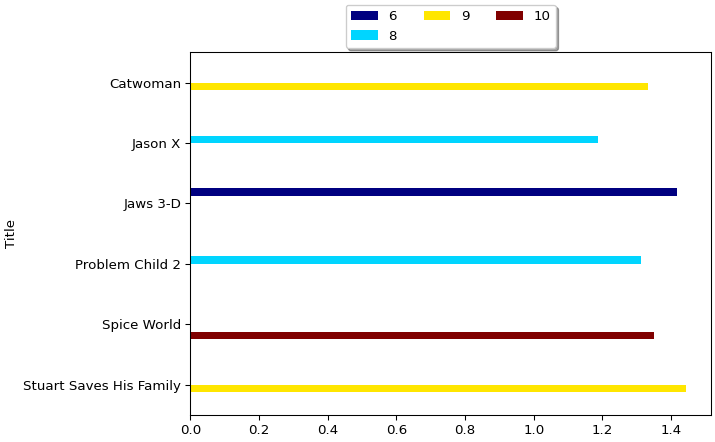

In [73]:
display(LR_LC)


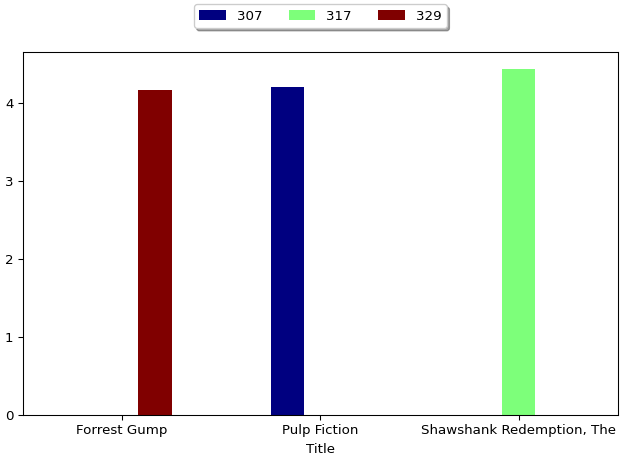

In [74]:
display(HR_HC)


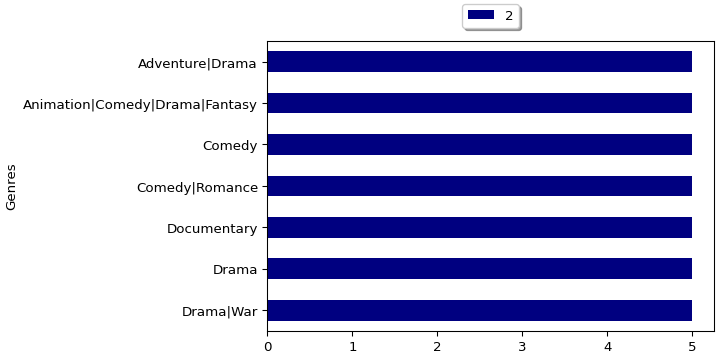

In [75]:
display(No_Significance_TT)


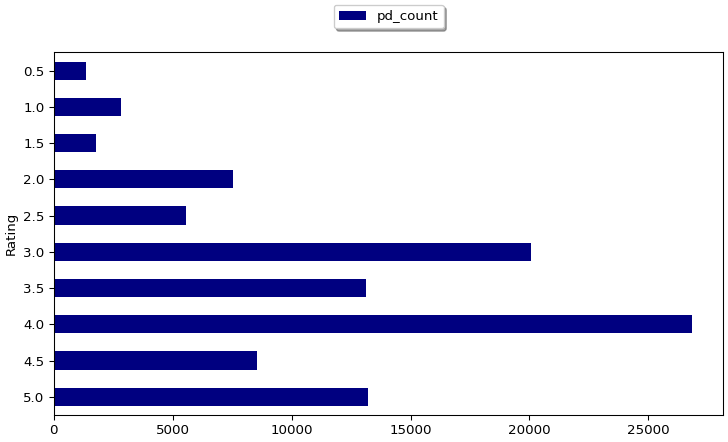

In [76]:
display(whole_data)

# Machine Learning Aproach

In [77]:
# Splitting the data into training and test set.

(training,test)=ratings.randomSplit([0.7,0.3])

Alternating Least Squares (ALS) is a matrix factorisation technique that tries to estimate the ratings matrix as the product of two lower-rank matrices. It's a loop. One of the factor matrices is held unchanged throughout each iteration, while the other is solved using least squares. While solving for the other factor matrix, the newly solved factor matrix is kept constant.


ALS can overcome two big challenges-

Sparsity- Not all items will be rated so there will be lot of blank infrmation in user item matrix.
Cold start problem- Addition of a new user or a new item where both do not have history in terms of ratings.
Model parameters for ALS are-

- maxIter- number of iterations ALS will do.
- regParam- the regularization parameter in ALS 
- userCol,itemCol and ratingCol are the setting features
- coldStartStrategy - when prediction is run and a model is not trained for a particular user/ ratings or items are not found for a user then it will drop those users if given “drop” as parameter’s value.

In [78]:
# Creating ALS Model

als=ALS(maxIter=5,regParam=0.01,userCol="User_ID",itemCol="Movie_ID",ratingCol="Rating",coldStartStrategy="drop")

In [79]:
model=als.fit(training)

In [80]:
predictions=model.transform(test)

In [81]:
# Defining the evaluation as ROOT MEAN SQUARED ERROR (RMSE).

evaluator=RegressionEvaluator(metricName="rmse",labelCol="Rating",predictionCol="prediction")

In [82]:
rmse=evaluator.evaluate(predictions)

In [83]:
print("RMSE="+str(rmse))

RMSE=1.1285110822664135


In [84]:
als=ALS(userCol="User_ID",itemCol="Movie_ID",ratingCol="Rating",coldStartStrategy="drop",nonnegative=True)

#param_grid=ParamGridBuilder().addGrid(als.rank,[5,10,15]).addGrid(als.maxIter,[5,10,15]).addGrid(als.regParam,[0.01,0.05,0.1]).build()

#evaluator=RegressionEvaluator(metricName="rmse",labelCol="rating",predictionCol="prediction")

#tvs=TrainValidationSplit(estimator=als,estimatorParamMaps=param_grid,evaluator=evaluator)



In [85]:
#Tuning the model using the parameter grid builder

param_grid = ParamGridBuilder()\
             .addGrid(als.rank,[5,10,15])\
             .addGrid(als.maxIter,[5,10,15])\
             .addGrid(als.regParam,[0.01,0.05,0.1])\
             .build()


In [86]:
display(param_grid)

ALS_17890becabfc__rank,ALS_17890becabfc__maxIter,ALS_17890becabfc__regParam
5.0,5.0,0.01
5.0,5.0,0.05
5.0,5.0,0.1
5.0,10.0,0.01
5.0,10.0,0.05
5.0,10.0,0.1
5.0,15.0,0.01
5.0,15.0,0.05
5.0,15.0,0.1
10.0,5.0,0.01


In [87]:
# Defining the evaluation as ROOT MEAN SQUARED ERROR (RMSE).

evaluator=RegressionEvaluator(metricName="rmse",labelCol="Rating",predictionCol="prediction")

In [88]:
display(evaluator)

RegressionEvaluator_333463dc6bd9

In [89]:
# Building cross validation using the TRAINVALIDATIONSPLIT METHOD.

TVS = TrainValidationSplit(
      estimator=als,
      estimatorParamMaps=param_grid,
      evaluator=evaluator)

In [90]:
# Fitting ALS Model to the training data.

model = TVS.fit(training)

In [91]:
# Extracting the best model from the tuning excercise with the help of ParamGridBuilder.

best_model=model.bestModel

# This will help us generate the  pridictions and evaluate using RMSE.

predictions=best_model.transform(test)
rmse=evaluator.evaluate(predictions)

In [92]:
print("RMSE="+str(rmse))
print("Rank="+str(best_model.rank))
print("MaxIter="+str(best_model._java_obj.parent().getMaxIter()))
print("RegParam="+str(best_model._java_obj.parent().getRegParam()))

RMSE=0.8875633396860182
Rank=5
MaxIter=15
RegParam=0.1


In [93]:
z=best_model.recommendForAllUsers(10).sort("User_ID")

In [94]:
display(z)

User_ID,recommendations
10,"[Row(Movie_ID=26614, rating=5.133164882659912), Row(Movie_ID=8973, rating=5.111298561096191), Row(Movie_ID=4821, rating=4.984976291656494), Row(Movie_ID=3701, rating=4.768939018249512), Row(Movie_ID=3404, rating=4.743752479553223), Row(Movie_ID=98083, rating=4.734078407287598), Row(Movie_ID=78637, rating=4.731886386871338), Row(Movie_ID=7842, rating=4.720756530761719), Row(Movie_ID=55241, rating=4.711807727813721), Row(Movie_ID=104925, rating=4.669059753417969)]"
17,"[Row(Movie_ID=6818, rating=5.517902851104736), Row(Movie_ID=7842, rating=5.494321346282959), Row(Movie_ID=33649, rating=5.142359733581543), Row(Movie_ID=187, rating=5.092215538024902), Row(Movie_ID=179135, rating=5.075789451599121), Row(Movie_ID=84273, rating=5.075789451599121), Row(Movie_ID=26073, rating=5.075789451599121), Row(Movie_ID=72171, rating=5.075789451599121), Row(Movie_ID=74226, rating=5.075789451599121), Row(Movie_ID=7071, rating=5.075789451599121)]"
33,"[Row(Movie_ID=4789, rating=5.7640461921691895), Row(Movie_ID=132333, rating=5.497681140899658), Row(Movie_ID=5490, rating=5.497681140899658), Row(Movie_ID=85774, rating=5.477228164672852), Row(Movie_ID=5915, rating=5.370112419128418), Row(Movie_ID=80906, rating=5.341545581817627), Row(Movie_ID=174053, rating=5.265592575073242), Row(Movie_ID=2843, rating=5.225342750549316), Row(Movie_ID=8542, rating=5.216403961181641), Row(Movie_ID=26471, rating=5.208304405212402)]"
37,"[Row(Movie_ID=7842, rating=6.3303327560424805), Row(Movie_ID=4789, rating=6.070205211639404), Row(Movie_ID=2843, rating=5.880115032196045), Row(Movie_ID=80906, rating=5.817307472229004), Row(Movie_ID=85774, rating=5.777103900909424), Row(Movie_ID=60943, rating=5.697299957275391), Row(Movie_ID=86347, rating=5.6549882888793945), Row(Movie_ID=136469, rating=5.5997209548950195), Row(Movie_ID=1251, rating=5.562978744506836), Row(Movie_ID=69524, rating=5.517935752868652)]"
50,"[Row(Movie_ID=6818, rating=4.036270618438721), Row(Movie_ID=3473, rating=3.957252025604248), Row(Movie_ID=32582, rating=3.9348950386047363), Row(Movie_ID=5490, rating=3.9193661212921143), Row(Movie_ID=132333, rating=3.9193661212921143), Row(Movie_ID=213, rating=3.9090383052825928), Row(Movie_ID=7982, rating=3.8892173767089844), Row(Movie_ID=7767, rating=3.8562233448028564), Row(Movie_ID=6380, rating=3.852475643157959), Row(Movie_ID=6192, rating=3.8513176441192627)]"
51,"[Row(Movie_ID=6818, rating=6.913564682006836), Row(Movie_ID=8477, rating=6.450450897216797), Row(Movie_ID=25771, rating=6.310897350311279), Row(Movie_ID=58301, rating=6.016693115234375), Row(Movie_ID=71899, rating=5.998103141784668), Row(Movie_ID=26326, rating=5.931576728820801), Row(Movie_ID=89904, rating=5.928600788116455), Row(Movie_ID=112421, rating=5.868589878082275), Row(Movie_ID=187, rating=5.83668851852417), Row(Movie_ID=143367, rating=5.805405616760254)]"
54,"[Row(Movie_ID=6818, rating=4.389226913452148), Row(Movie_ID=7842, rating=4.078835964202881), Row(Movie_ID=3200, rating=4.015368938446045), Row(Movie_ID=7096, rating=3.9778692722320557), Row(Movie_ID=89904, rating=3.961576223373413), Row(Movie_ID=33649, rating=3.932234764099121), Row(Movie_ID=945, rating=3.9200973510742188), Row(Movie_ID=187, rating=3.9004056453704834), Row(Movie_ID=132333, rating=3.892913579940796), Row(Movie_ID=5490, rating=3.892913579940796)]"
57,"[Row(Movie_ID=6818, rating=5.534084320068359), Row(Movie_ID=89904, rating=4.991570949554443), Row(Movie_ID=8477, rating=4.963631629943848), Row(Movie_ID=26326, rating=4.953790187835693), Row(Movie_ID=26258, rating=4.91140079498291), Row(Movie_ID=25771, rating=4.8985209465026855), Row(Movie_ID=5490, rating=4.869203567504883), Row(Movie_ID=132333, rating=4.869203567504883), Row(Movie_ID=7096, rating=4.865245819091797), Row(Movie_ID=71899, rating=4.824077606201172)]"
60,"[Row(Movie_ID=6818, rating=5.535737037658691), Row(Movie_ID=33649, rating=5.408332347869873), Row(Movie_ID=7842, rating=5.353152275085449), Row(Movie_ID=123, rating=5.235980987548828), R

In [95]:
# Sorting Predictions by User_ID and Rating

predictions.sort("User_ID", "Rating")

DataFrame[User_ID: int, Movie_ID: int, Rating: double, prediction: float]


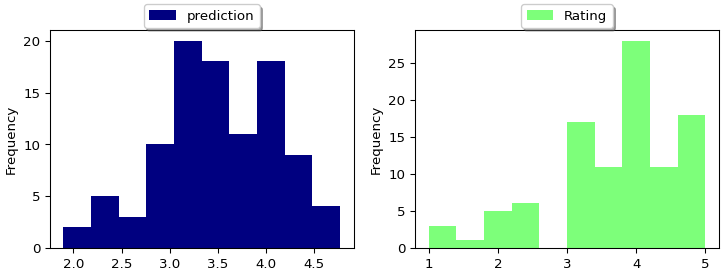

In [96]:
display(predictions)

In [97]:
def get_rec(rec):
  rec=rec.select("User_ID",explode(rec.recommendations))
  rec=rec.select("col.*","*")
  rating_mat=rec.select(["User_ID","Movie_ID","Rating"])
  return rating_mat

In [98]:
# Recommender for all users 

rating_mat=get_rec(best_model.recommendForAllUsers(8))

In [99]:
rating_mat.show()

+-------+--------+---------+
|User_ID|Movie_ID|   Rating|
+-------+--------+---------+
|    471|    6818|5.3778715|
|    471|     187|4.9721937|
|    471|    6460|4.7400627|
|    471|   89904| 4.723738|
|    471|     945| 4.720935|
|    471|   58301| 4.718861|
|    471|   27611| 4.679072|
|    471|    2131|4.6771307|
|    463|    7842| 5.646953|
|    463|   60943|5.0822577|
|    463|   72171| 4.824198|
|    463|  179135| 4.824198|
|    463|   26073| 4.824198|
|    463|   74226| 4.824198|
|    463|    7071| 4.824198|
|    463|   84273| 4.824198|
|    496|    4789| 5.574222|
|    496|    3503| 5.060878|
|    496|   85774|4.7671204|
|    496|    1251|4.6967373|
+-------+--------+---------+
only showing top 20 rows



In [100]:
Result_df=rating_mat.join(movies,['Movie_ID'],how='left')

In [101]:
# Display train data

Result_df.filter("User_ID=14").orderBy(Result_df["Rating"].desc()).show(10)

+--------+-------+---------+--------------------+--------------------+
|Movie_ID|User_ID|   Rating|               Title|              Genres|
+--------+-------+---------+--------------------+--------------------+
|    7842|     14|5.2088614|         Dune (2000)|Drama|Fantasy|Sci-Fi|
|    6818|     14|5.1523747|Come and See (Idi...|           Drama|War|
|   42730|     14| 5.036359|   Glory Road (2006)|               Drama|
|   25906|     14| 4.986349|Mr. Skeffington (...|       Drama|Romance|
|   77846|     14| 4.986349| 12 Angry Men (1997)|         Crime|Drama|
|   93008|     14| 4.986349|Very Potter Seque...|      Comedy|Musical|
|    3200|     14| 4.936701|Last Detail, The ...|        Comedy|Drama|
|   92643|     14| 4.927156|Monsieur Lazhar (...|Children|Comedy|D...|
+--------+-------+---------+--------------------+--------------------+



In [102]:
# Display test data 

Test_df=movies.join(ratings,['Movie_ID'],how='left')
Test_df.filter("User_ID=14").orderBy(Test_df["Rating"].desc()).show(10)

+--------+--------------------+--------------------+-------+------+
|Movie_ID|               Title|              Genres|User_ID|Rating|
+--------+--------------------+--------------------+-------+------+
|     110|   Braveheart (1995)|    Action|Drama|War|     14|   5.0|
|      47|Seven (a.k.a. Se7...|    Mystery|Thriller|     14|   5.0|
|     337|What's Eating Gil...|               Drama|     14|   5.0|
|     509|   Piano, The (1993)|       Drama|Romance|     14|   5.0|
|     266|Legends of the Fa...|Drama|Romance|War...|     14|   5.0|
|      95| Broken Arrow (1996)|Action|Adventure|...|     14|   5.0|
|     282|         Nell (1994)|               Drama|     14|   5.0|
|      32|Twelve Monkeys (a...|Mystery|Sci-Fi|Th...|     14|   4.0|
|      25|Leaving Las Vegas...|       Drama|Romance|     14|   4.0|
|     339|While You Were Sl...|      Comedy|Romance|     14|   4.0|
+--------+--------------------+--------------------+-------+------+
only showing top 10 rows

